# Interactive Scribbles Robot

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from PIL import Image
%matplotlib inline

from davisinteractive.metrics.jaccard import batched_jaccard
from davisinteractive.robot import InteractiveScribblesRobot
from davisinteractive.utils.operations import bezier_curve

mpl.rcParams['figure.dpi'] = 300

Define some global variables like the path to the DAVIS dataset.

In [2]:
DAVIS_DATASET = '/Users/alberto/Workspace/CVL/datasets/davis-2017/data/DAVIS/'
RESULTS_FOLDER = './files/'
SEQUENCE = 'breakdance'
COLORMAP = np.load('files/pascal_colormap.npy')
NB_IMAGES = 8

Helper functions:

In [3]:
def num_images(folder):
    l = [f for f in os.listdir(folder) if not f.startswith('.')]
    return len(l)

def load_sequence(sequence):
    annotations_folder = os.path.join(DAVIS_DATASET, 'Annotations', '480p', sequence)
    sequence_folder = os.path.join(RESULTS_FOLDER, sequence)
    image_folder = os.path.join(DAVIS_DATASET, 'JPEGImages', '480p', sequence)
    nb_frames = num_images(sequence_folder)

    predictions = np.empty((nb_frames, 480, 854), dtype=np.uint8)
    annotations = np.empty((nb_frames, 480, 854), dtype=np.uint8)
    images = []

    for f in range(nb_frames):
        img_pred = Image.open(os.path.join(sequence_folder, 
                                           f'{f:05d}.png'))
        img_anno = Image.open(os.path.join(annotations_folder, 
                                           f'{f:05d}.png'))
        img_img = Image.open(os.path.join(image_folder, f'{f:05d}.jpg'))
        img_pred, img_anno = np.asarray(img_pred), np.asarray(img_anno)
        predictions[f] = img_pred
        annotations[f] = img_anno
        images.append(img_img)
    return images, annotations, predictions

def map2rgb(arr):
    return COLORMAP[arr.ravel()][:,:3].reshape(arr.shape + (3,))

Load a sequence's annotations and predictions:

In [4]:
images, annotations, predictions = load_sequence(SEQUENCE)

## Example Sequence

Check on DAVIS sequence and an example of prediction by some DL model:

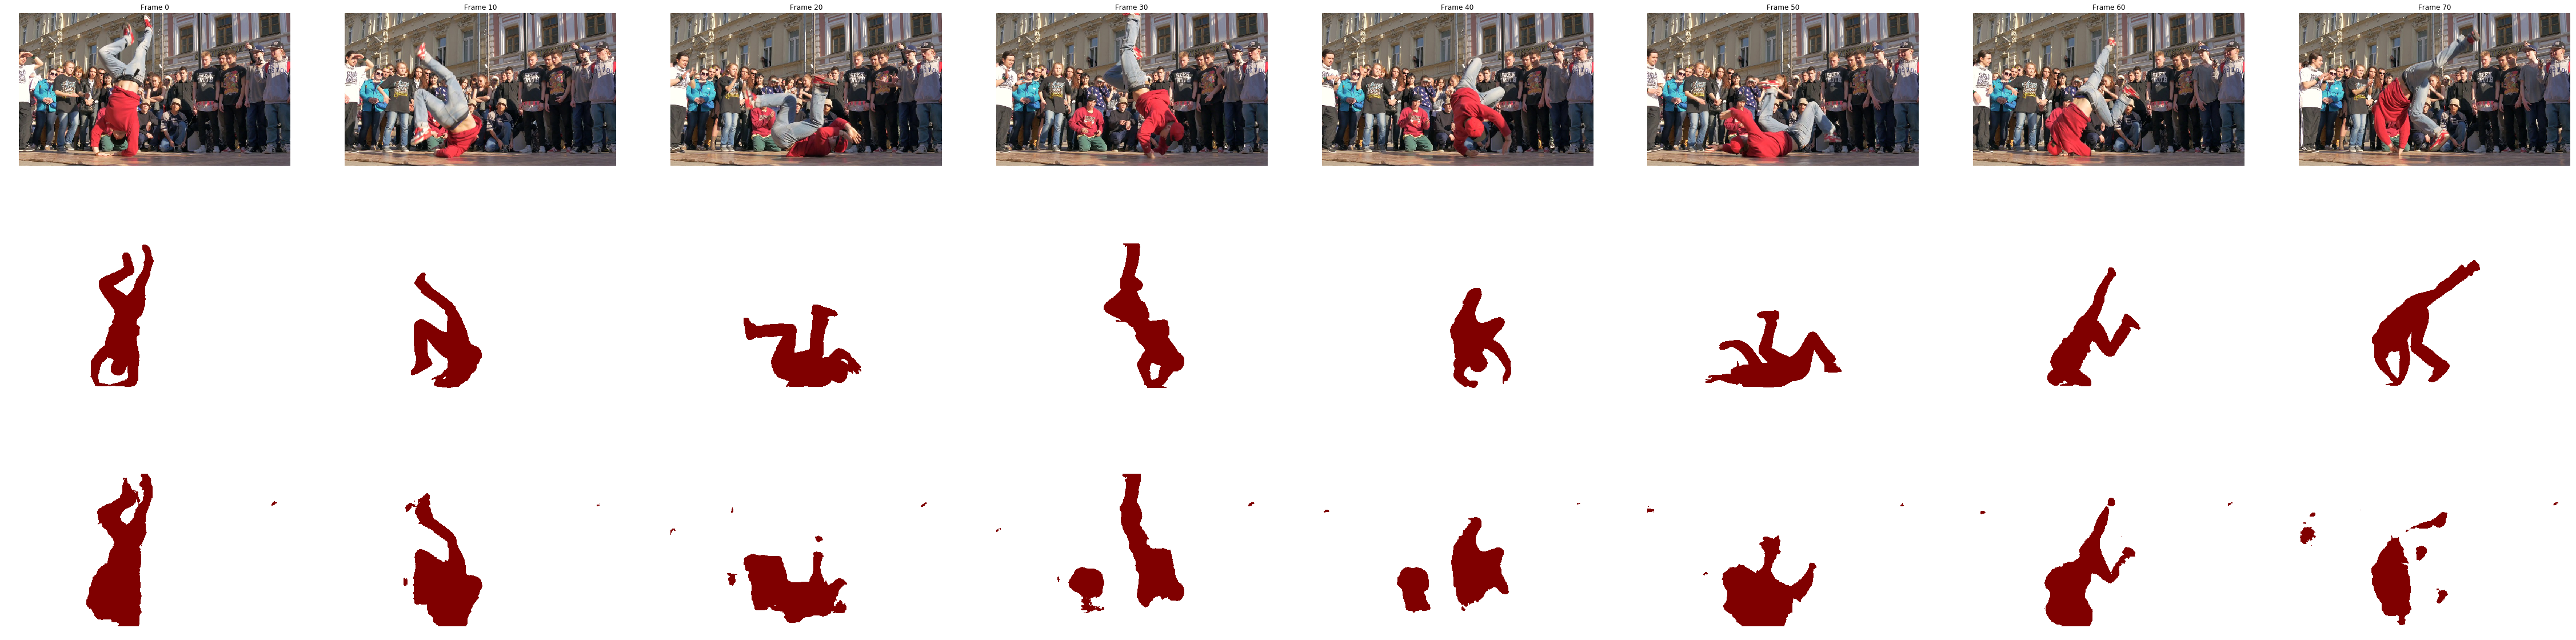

In [5]:
nb_frames = len(annotations)

step = nb_frames // NB_IMAGES

fig, ax = plt.subplots(3, NB_IMAGES, figsize=(10*NB_IMAGES, 7*3))

for i in range(0, NB_IMAGES):
    idx = i * (nb_frames // NB_IMAGES)
    ax[0][i].imshow(images[idx])
    ax[0][i].axis('off')
    ax[0][i].set_title(f'Frame {idx}')
    
    ax[1][i].imshow(map2rgb(annotations[idx]))
    ax[1][i].axis('off')
    
    ax[2][i].imshow(map2rgb(predictions[idx]))
    ax[2][i].axis('off')
    
plt.show()

Worst jaccard at frame 22


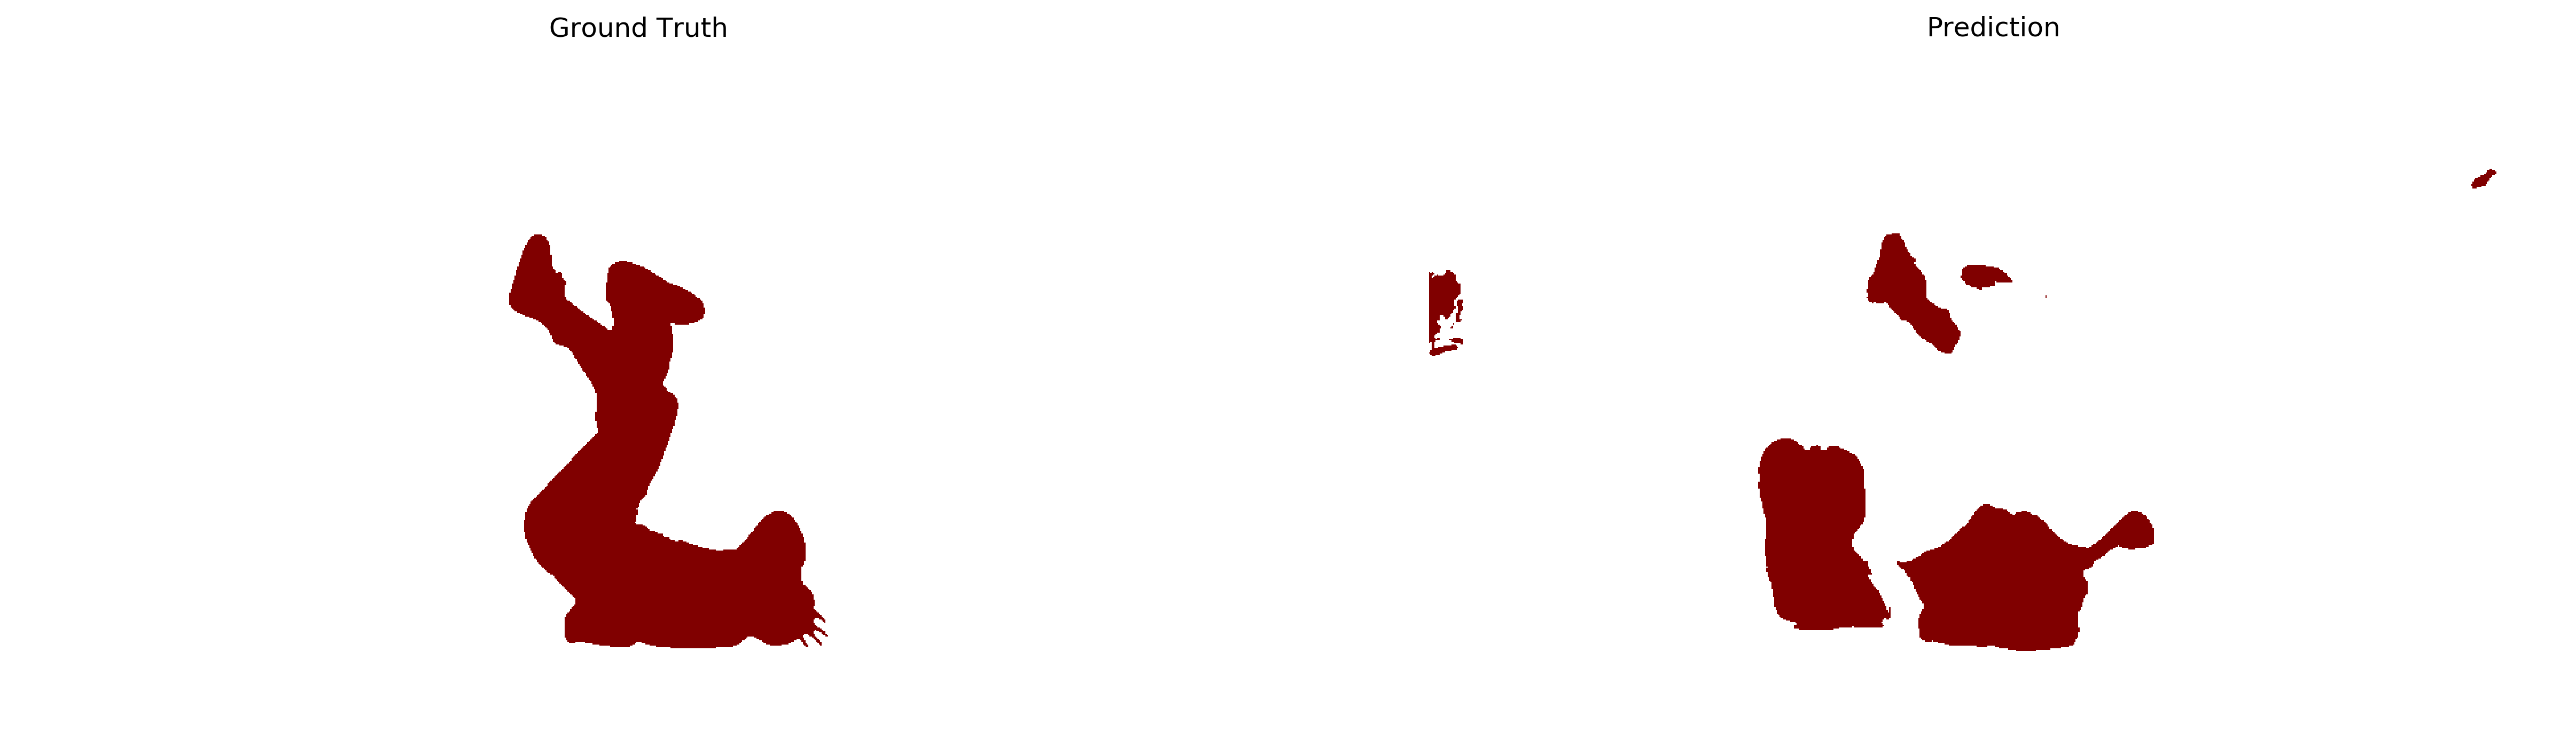

In [6]:
jac = batched_jaccard(annotations, predictions)
worst_frame = jac.argmin()
print(f'Worst jaccard at frame {worst_frame}')

nb_frames = len(annotations)
nb_objects = np.unique(annotations).max()
scribbles = [[] for _ in range(nb_frames)]

gt = annotations[worst_frame]
pred = predictions[worst_frame]

fig, ax = plt.subplots(1, 2, figsize=(20, 8), dpi=300)

ax[0].imshow(map2rgb(gt))
ax[0].set_title('Ground Truth')
ax[0].axis('off')

ax[1].imshow(map2rgb(pred))
ax[1].set_title('Prediction')
ax[1].axis('off')
plt.show()

We have implemented a robot which tries to give additional scribbles annotations given some prediction trying to emulate a simple human annotation: simple lines to reannotate the zones where there has been an error and try to give the best feedback to the segmentation model.

In [7]:
robot = InteractiveScribblesRobot()

The fisrt of the robot interaction is take the frame that has worst jaccard and work with the error mask for each object id present in the DAVIS sequence.

In this example, as there are only two object instances (background and the car or foreground) for each object instance is computed the error mask. This mask for the background would correspond to the false positives and for the foreground object will be the false negatives.

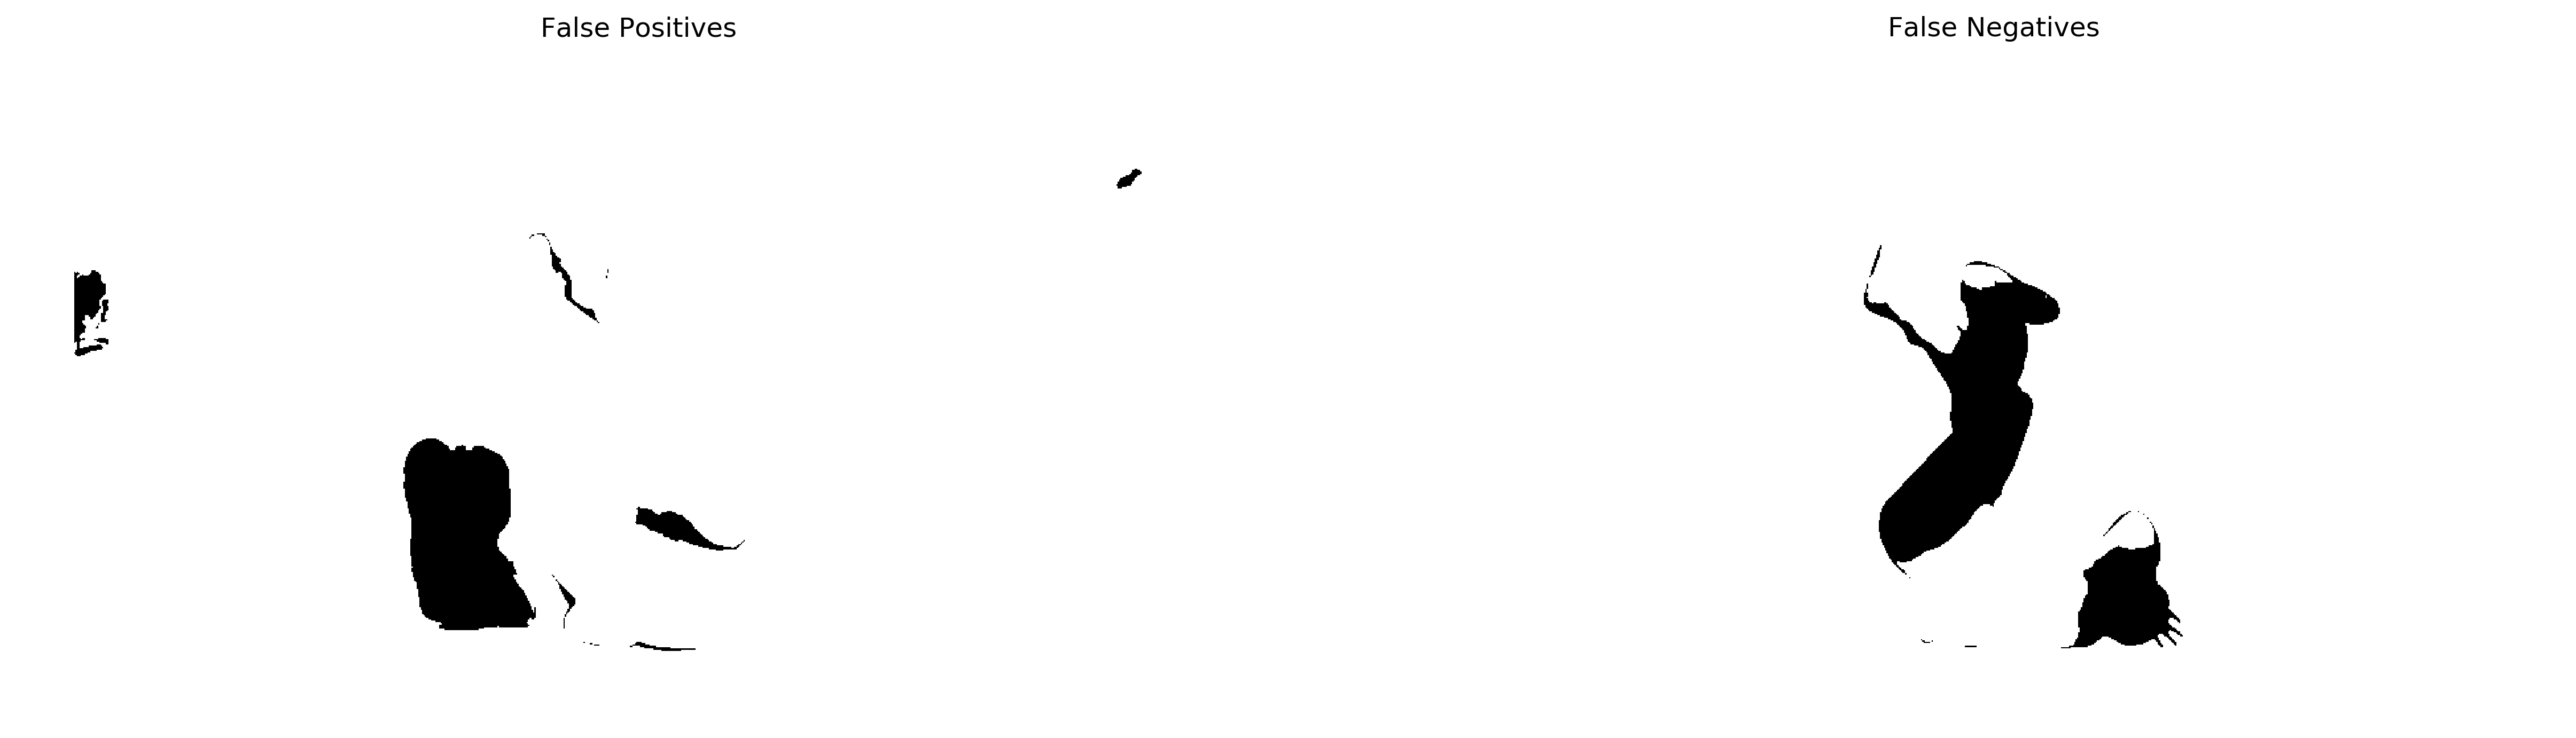

In [8]:
names = ['False Positives', 'False Negatives']

# Compute error mask
error_masks = [(gt == obj_id) & (pred != obj_id) for obj_id in range(nb_objects + 1)]

_, ax = plt.subplots(1, 2, figsize=(20, 8), dpi=300)
for obj_id in range(nb_objects + 1):
    ax[obj_id].imshow(error_masks[obj_id], cmap='gray_r')
    ax[obj_id].axis('off')
    ax[obj_id].set_title(names[obj_id])
plt.show()

The next step is to compute the skeleton for all this error mask after applying some erosion and dilation to remove small objects.

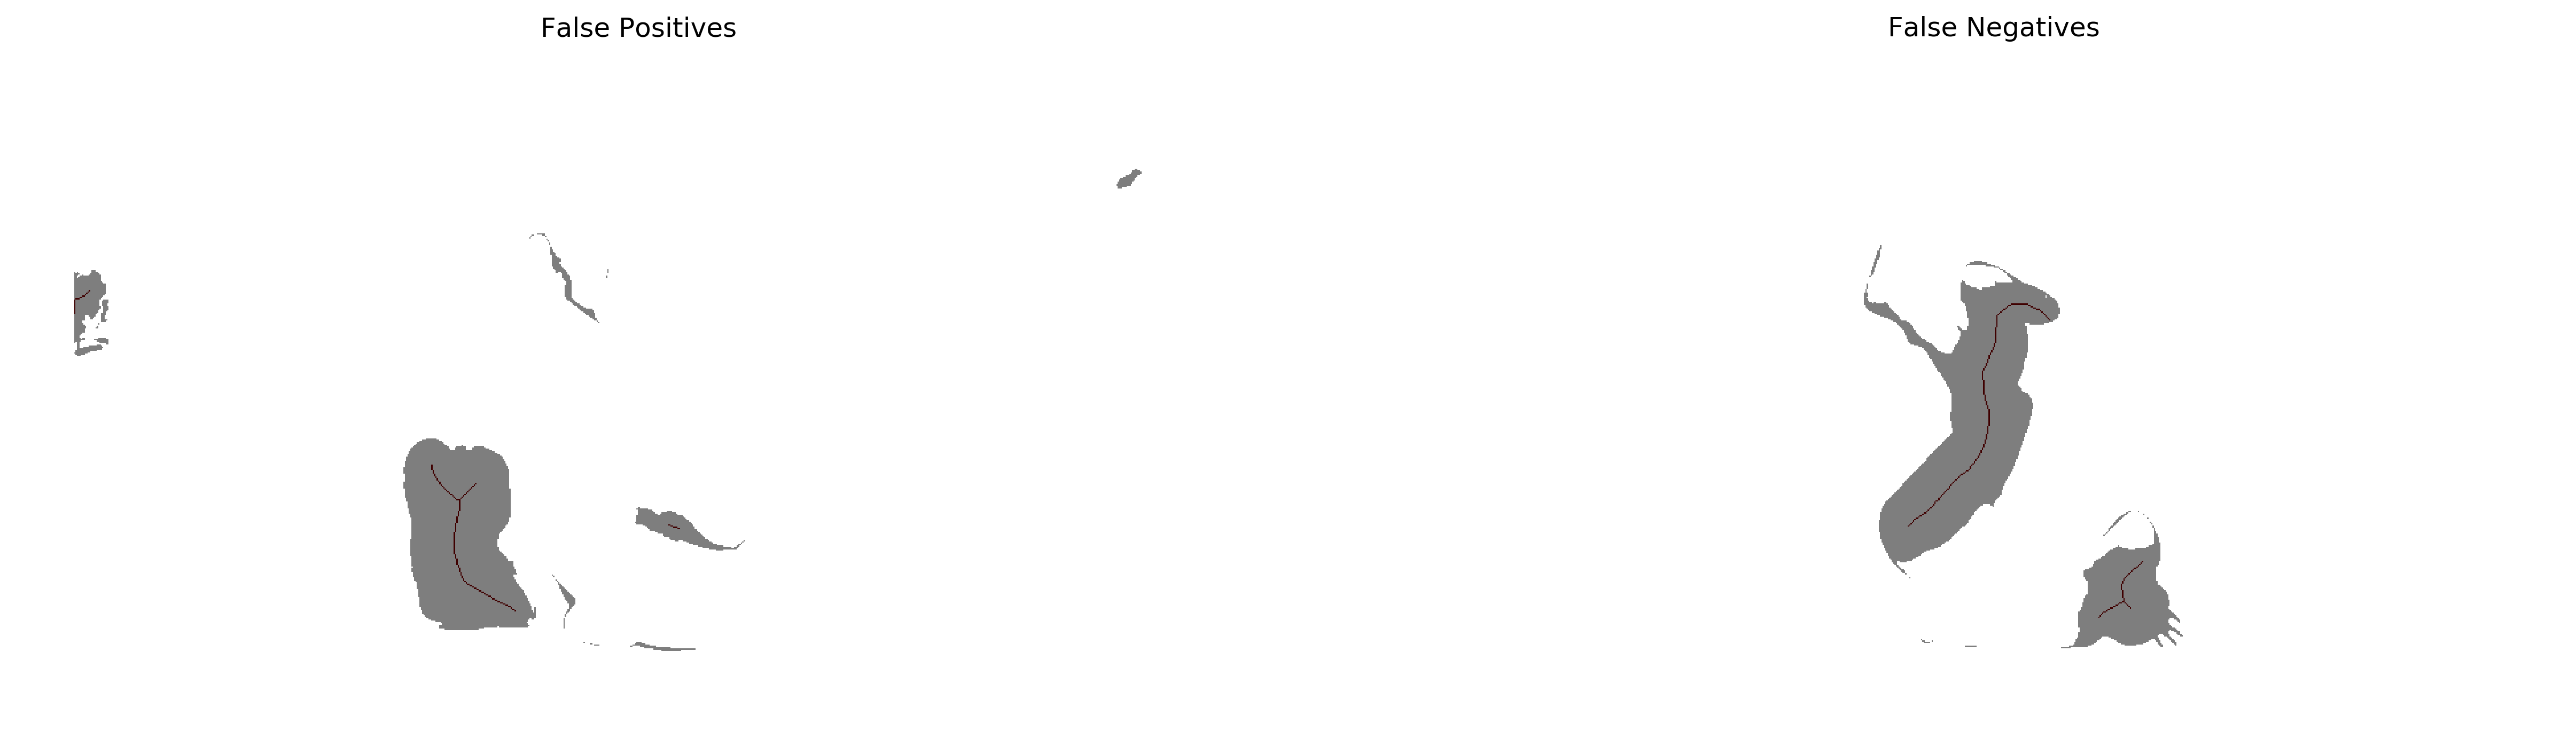

In [9]:
# Compute skeleton mask 
skel_masks = [robot._generate_scribble_mask(m) for m in error_masks]

_, ax = plt.subplots(1, 2, figsize=(20, 8), dpi=300)
for obj_id in range(nb_objects + 1):
    skel_mask = skel_masks[obj_id].astype(np.int)
    skel_mask = map2rgb(skel_mask)
    ax[obj_id].imshow(error_masks[obj_id], cmap='gray_r')
    ax[obj_id].imshow(skel_mask, cmap='gray_r', alpha=.5)
    ax[obj_id].axis('off')
    ax[obj_id].set_title(names[obj_id])
plt.show()

The next step is to transform the skeleton mask into a graph using a radius neightbors method.

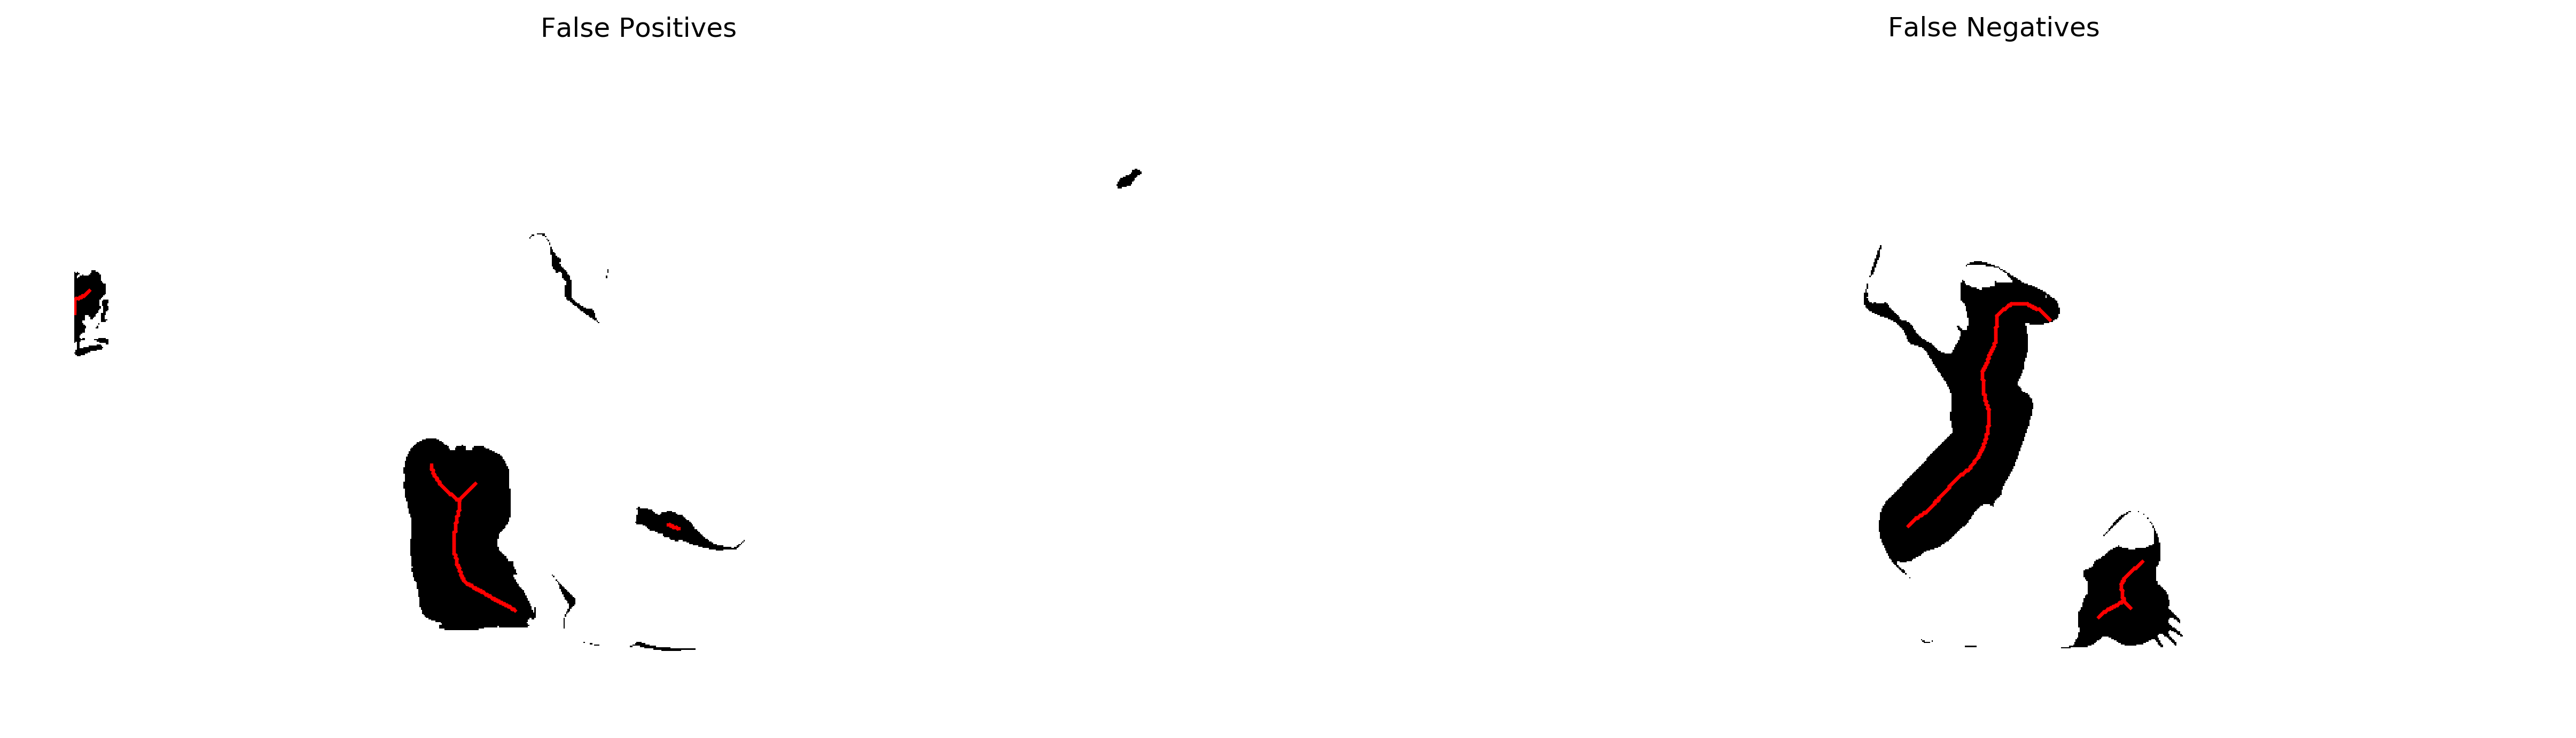

In [10]:
mask_graphs = [robot._mask2graph(m) for m in skel_masks]

def plot_graph(G, P, ax, linecolor='r'):
#     ax.scatter(*P.T, color='b', marker='.', label='nodes')
    for u, v in G.edges():
        a, b = P[u], P[v]
        line = np.c_[a, b]
        ax.plot(*line, c=linecolor)
        
_, ax = plt.subplots(1, 2, figsize=(20, 8), dpi=300)
for obj_id in range(nb_objects + 1):
    G, P = mask_graphs[obj_id]
    skel_mask = map2rgb(skel_mask)
    ax[obj_id].imshow(error_masks[obj_id], cmap='gray_r')
    plot_graph(G, P, ax[obj_id])
    ax[obj_id].axis('off')
    ax[obj_id].set_title(names[obj_id])
plt.show()

The next step is to separate each graph into its connected components and then remove any existing cycle to obtain a tree graph.

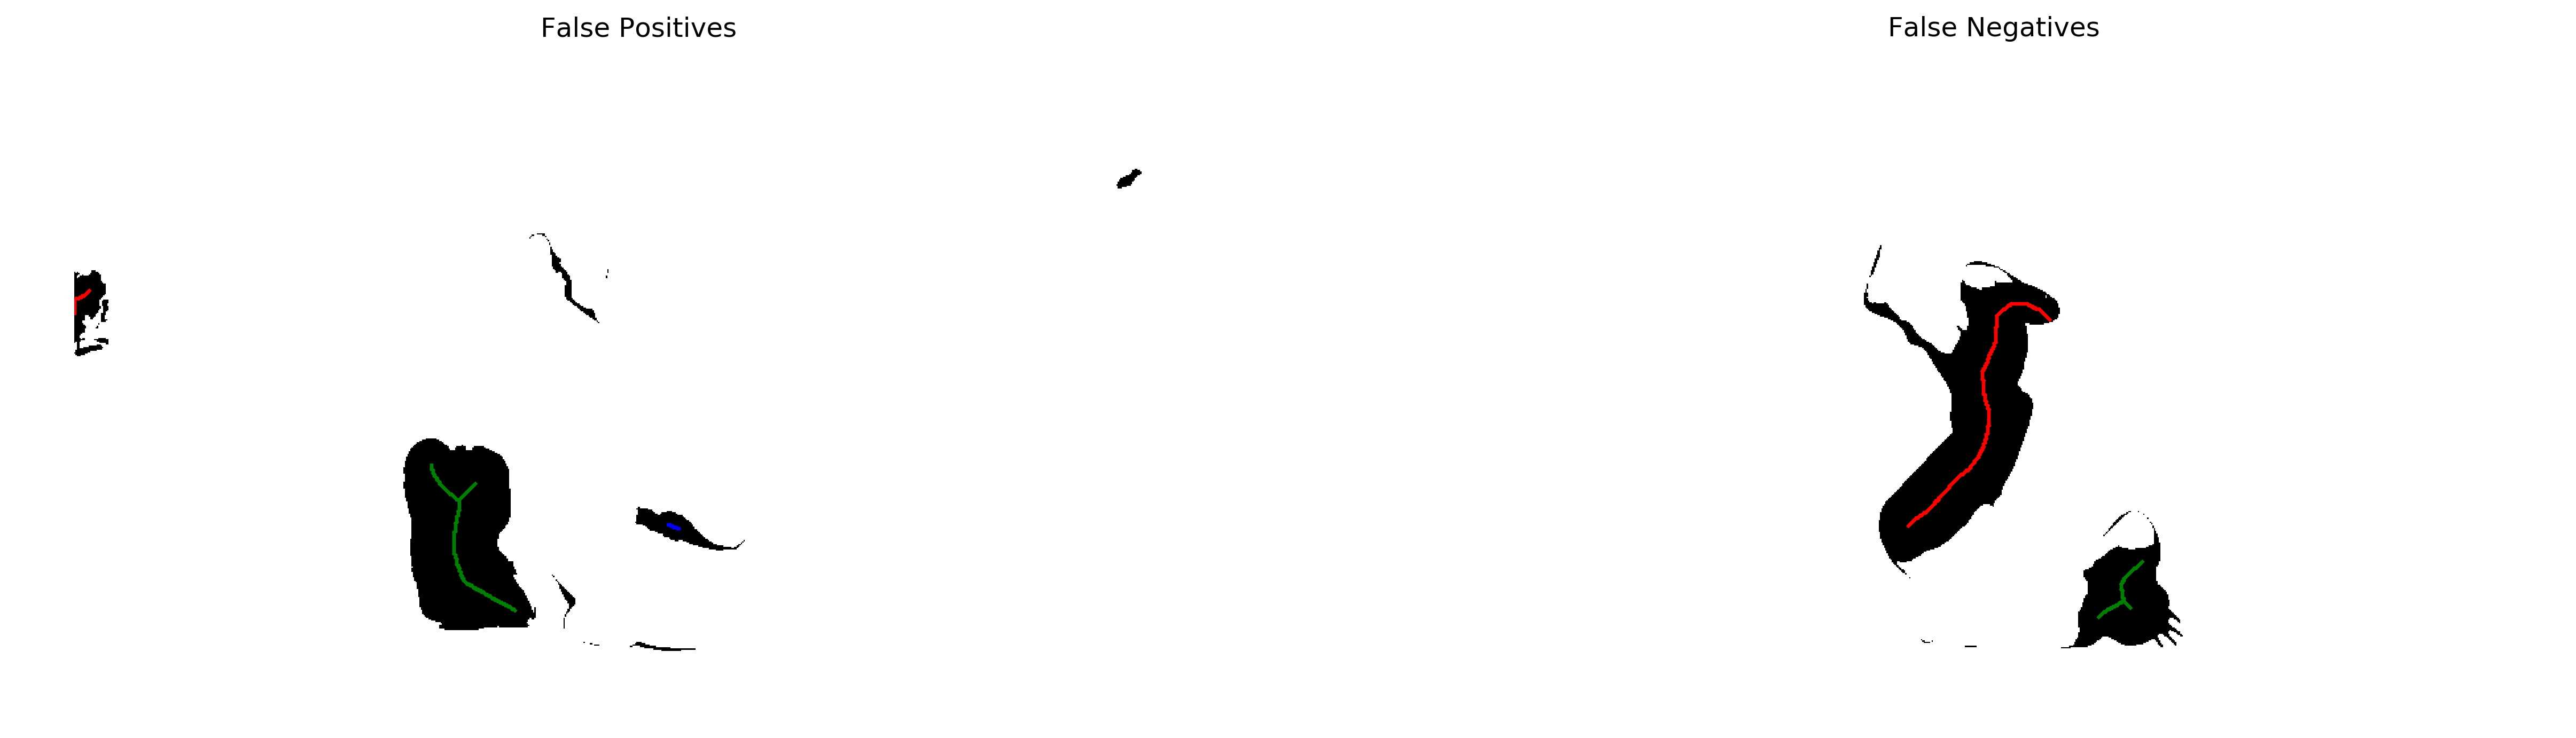

In [11]:
components = [robot._acyclics_subgraphs(G[0]) for G in mask_graphs]
colors = ['r', 'g', 'b', 'y']

_, ax = plt.subplots(1, 2, figsize=(20, 8), dpi=300)
for obj_id in range(nb_objects + 1):
    G, P = mask_graphs[obj_id]
    S = components[obj_id]
    ax[obj_id].imshow(error_masks[obj_id], cmap='gray_r')
    for i, s in enumerate(S):
        plot_graph(s, P, ax[obj_id], linecolor=colors[i])
    ax[obj_id].axis('off')
    ax[obj_id].set_title(names[obj_id])
plt.show()

We can see how for each error mask, we obtain two connected tree graphs that correspond to the two major connected areas that have made the biggest impact to the low jaccard.

The final steps, and in order to make a realistic consist on from each tree graph, extract the longest path in each tree graph and return its path to become the scribble.

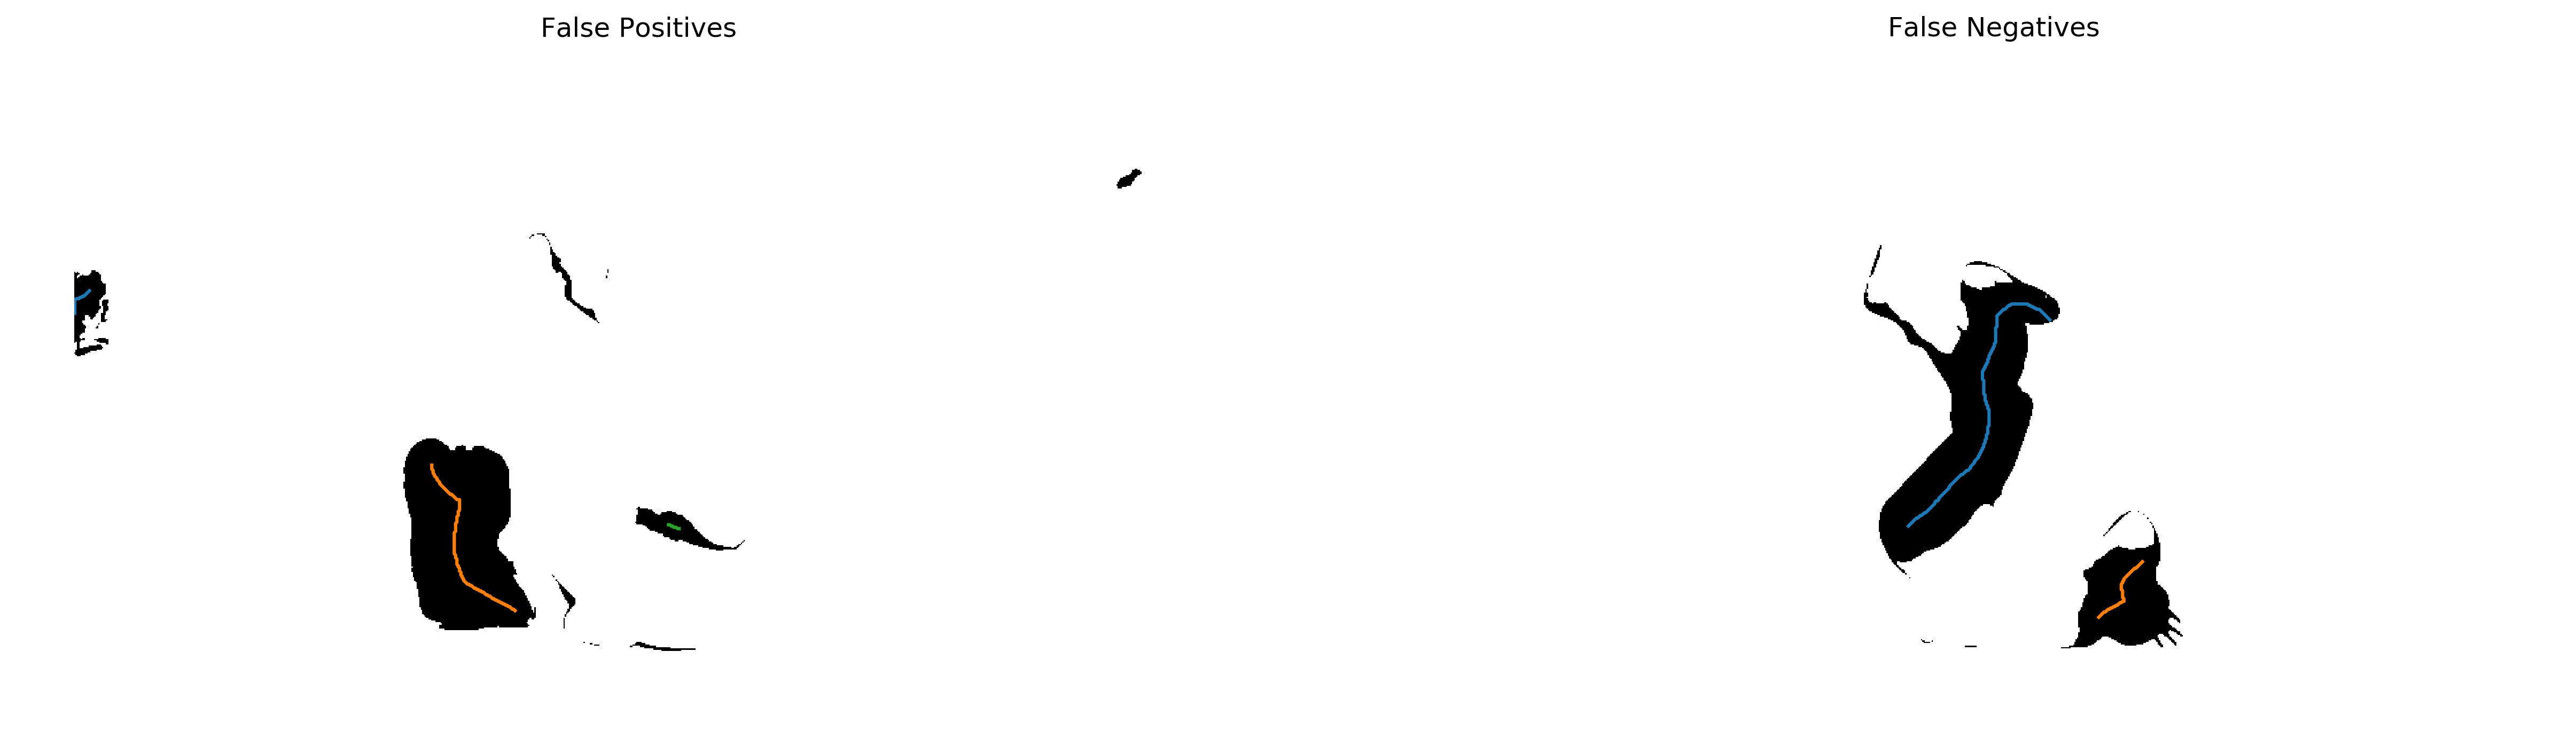

In [12]:
scribbles = [[GP[1][robot._longest_path_in_tree(s)] for s in components[i]] for i, GP in enumerate(mask_graphs)]

_, ax = plt.subplots(1, 2, figsize=(20, 8), dpi=300)
for obj_id in range(nb_objects + 1):
    sc = scribbles[obj_id]
    ax[obj_id].imshow(error_masks[obj_id], cmap='gray_r')
    for s in sc:
        ax[obj_id].plot(*s.T)
    ax[obj_id].axis('off')
    ax[obj_id].set_title(names[obj_id])
plt.show()

The final step (as a postprocessing) will be to compute a bezier curve for each resulting line, to make it more smooth as we can find that the lines (which originally come from a medial axis computation) are not very smooth in comparison with a persons scribble.

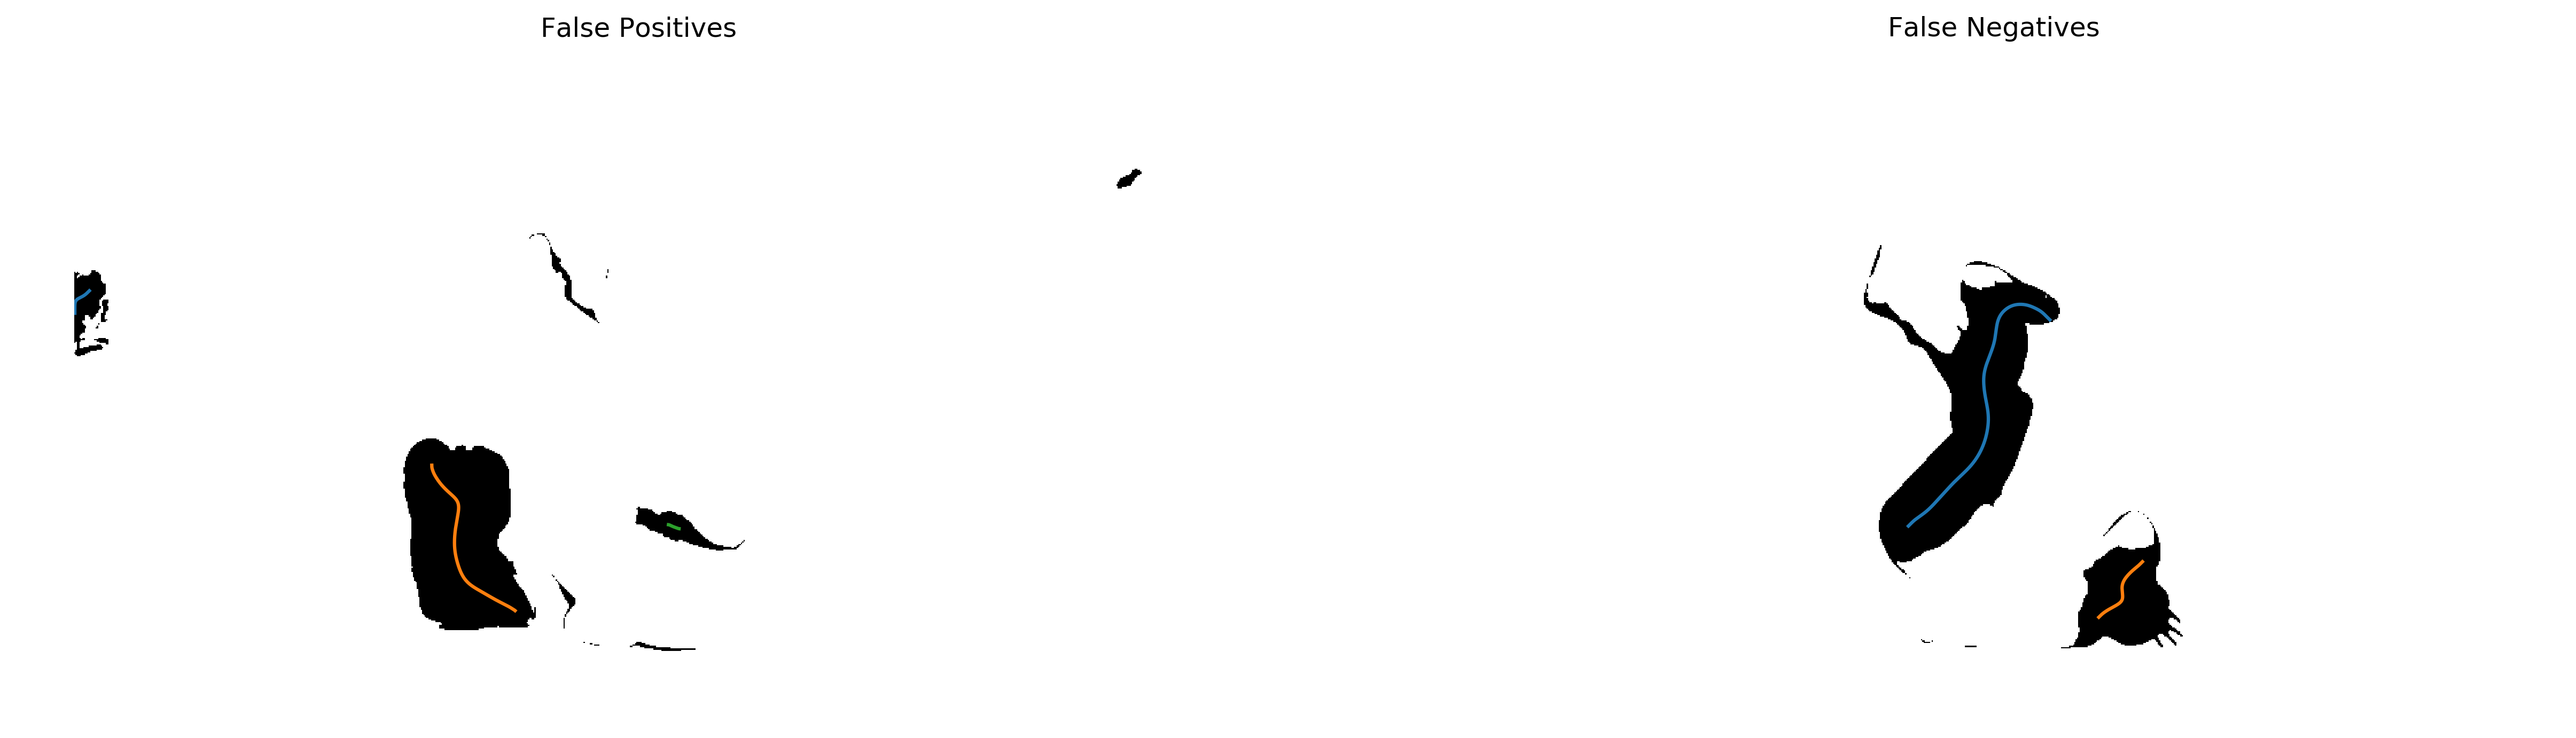

In [13]:
bezier_scribbles = [[bezier_curve(P) for P in sc] for sc in scribbles]
_, ax = plt.subplots(1, 2, figsize=(20, 8), dpi=300)
for obj_id in range(nb_objects + 1):
    sc = bezier_scribbles[obj_id]
    ax[obj_id].imshow(error_masks[obj_id], cmap='gray_r')
    for s in sc:
        ax[obj_id].plot(*s.T)
    ax[obj_id].axis('off')
    ax[obj_id].set_title(names[obj_id])
plt.show()